# 09.2a: Adjacency Graph and Connected Components

**Build adjacency graph from pairwise distances and analyze connected components**

Now that we have pairwise distances (from 09.1d), we can build the adjacency graph using threshold ε and analyze the connectivity structure.

## Key Questions

1. **Black hole structure:** Do the 13 unique black hole vectors form one connected component?
2. **Kissing cousins:** Are they connected to black holes or separate?
3. **Component distribution:** How many components total? Size distribution?
4. **Singletons:** How many vectors have no neighbors (isolated)?
5. **Density:** Is the largest component nearly complete (all nodes connected)?

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Input files
PAIRWISE_FILE = "neighborhood_pairwise_distances.safetensors"
DISTANCES_KEY = "distances_linf"
UNIQUE_VECTORS_KEY = "unique_vectors"
UNIQUE_TOKEN_IDS_KEY = "unique_token_ids"
INVERSE_KEY = "inverse_indices"

BLACK_HOLE_MASK_FILE = "black_hole_mask.safetensors"
BLACK_HOLE_MASK_KEY = "mask"

# Graph construction
# ε will be computed from actual vector scale
EPSILON_MULTIPLIER = 2.0  # 2×ULP

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading pairwise distances...")
pairwise_data = load_file(data_dir / PAIRWISE_FILE)
distances = pairwise_data[DISTANCES_KEY]
unique_vectors = pairwise_data[UNIQUE_VECTORS_KEY]
unique_token_ids = pairwise_data[UNIQUE_TOKEN_IDS_KEY]
inverse_indices = pairwise_data[INVERSE_KEY]

n_unique = len(unique_vectors)
print(f"  Unique vectors: {n_unique:,}")
print(f"  Distance matrix: {distances.shape}")
print()

print("Loading black hole mask...")
bh_data = load_file(data_dir / BLACK_HOLE_MASK_FILE)
black_hole_mask = bh_data[BLACK_HOLE_MASK_KEY]
print(f"  Total black holes in vocab: {black_hole_mask.sum().item():,}")
print()

print("✓ Data loaded")

Loading pairwise distances...
  Unique vectors: 499
  Distance matrix: torch.Size([499, 499])

Loading black hole mask...
  Total black holes in vocab: 2,100

✓ Data loaded


## Compute ε (Distinguishability Threshold)

In [4]:
def bfloat16_ulp(x):
    """Compute bfloat16 ULP at scale of x."""
    x = abs(x)
    if x == 0:
        return 2.0 ** (-133)
    exponent = int(np.floor(np.log2(x)))
    return 2.0 ** (exponent - 7)

print("Computing ε (distinguishability threshold)...\n")

typical_magnitude = unique_vectors.abs().mean().item()
ulp = bfloat16_ulp(typical_magnitude)
epsilon = EPSILON_MULTIPLIER * ulp

print(f"Typical component magnitude: {typical_magnitude:.6e}")
print(f"ULP at this scale:           {ulp:.6e}")
print(f"ε (2×ULP):                   {epsilon:.6e}")
print()
print("✓ ε computed")

Computing ε (distinguishability threshold)...

Typical component magnitude: 2.418461e-03
ULP at this scale:           1.525879e-05
ε (2×ULP):                   3.051758e-05

✓ ε computed


## Build Adjacency Graph

Two vectors are **adjacent** if their L∞ distance is ≤ ε.

Adjacency matrix: `A[i,j] = 1` if `d(i,j) ≤ ε`, else `0`.

In [5]:
print(f"Building adjacency graph with threshold ε = {epsilon:.6e}...\n")

# Boolean adjacency matrix
adjacency = (distances <= epsilon)

# Remove self-loops (diagonal)
mask = torch.eye(n_unique, dtype=torch.bool)
adjacency[mask] = False

# Count edges
n_edges = adjacency.sum().item() // 2  # Divide by 2 (undirected)
n_possible = n_unique * (n_unique - 1) // 2
density = n_edges / n_possible if n_possible > 0 else 0

print(f"Graph statistics:")
print(f"  Nodes:          {n_unique:,}")
print(f"  Edges:          {n_edges:,}")
print(f"  Possible edges: {n_possible:,}")
print(f"  Density:        {density:.4f} ({100*density:.2f}%)")
print()
print("✓ Adjacency graph built")

Building adjacency graph with threshold ε = 3.051758e-05...

Graph statistics:
  Nodes:          499
  Edges:          6,675
  Possible edges: 124,251
  Density:        0.0537 (5.37%)

✓ Adjacency graph built


## Degree Distribution

In [6]:
print("Computing node degrees...\n")

degree = adjacency.sum(dim=1)

print(f"Degree statistics:")
print(f"  Min:    {degree.min().item()}")
print(f"  Max:    {degree.max().item()}")
print(f"  Mean:   {degree.float().mean().item():.1f}")
print(f"  Median: {degree.float().median().item():.0f}")
print()

# How many singletons (degree 0)?
n_singletons = (degree == 0).sum().item()
n_connected = n_unique - n_singletons

print(f"Connectivity:")
print(f"  Connected nodes (degree > 0): {n_connected:,} ({100 * n_connected / n_unique:.1f}%)")
print(f"  Isolated nodes (degree = 0):  {n_singletons:,} ({100 * n_singletons / n_unique:.1f}%)")
print()
print("✓ Degrees computed")

Computing node degrees...

Degree statistics:
  Min:    0
  Max:    118
  Mean:   26.8
  Median: 0

Connectivity:
  Connected nodes (degree > 0): 119 (23.8%)
  Isolated nodes (degree = 0):  380 (76.2%)

✓ Degrees computed


## Find Connected Components

Use union-find algorithm to identify connected components.

In [7]:
class UnionFind:
    """Union-Find data structure for connected components."""
    
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n
    
    def find(self, x):
        """Find root with path compression."""
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]
    
    def union(self, x, y):
        """Merge components."""
        root_x = self.find(x)
        root_y = self.find(y)
        
        if root_x == root_y:
            return
        
        if self.rank[root_x] < self.rank[root_y]:
            self.parent[root_x] = root_y
        elif self.rank[root_x] > self.rank[root_y]:
            self.parent[root_y] = root_x
        else:
            self.parent[root_y] = root_x
            self.rank[root_x] += 1
    
    def get_components(self):
        """Return list of connected components."""
        components = defaultdict(list)
        for i in range(len(self.parent)):
            root = self.find(i)
            components[root].append(i)
        return list(components.values())

print("Finding connected components...\n")

uf = UnionFind(n_unique)

# Add edges
for i in range(n_unique):
    for j in range(i + 1, n_unique):
        if adjacency[i, j]:
            uf.union(i, j)

components = uf.get_components()

# Sort by size (largest first)
components = sorted(components, key=len, reverse=True)
n_components = len(components)

print(f"Connected components: {n_components:,}")
print()
print("✓ Components identified")

Finding connected components...

Connected components: 381

✓ Components identified


## Component Size Distribution

In [8]:
print("Component size distribution:\n")

sizes = [len(c) for c in components]

print(f"Statistics:")
print(f"  Largest component:  {sizes[0]:,} nodes ({100 * sizes[0] / n_unique:.1f}%)")
if len(sizes) > 1:
    print(f"  Second largest:     {sizes[1]:,} nodes ({100 * sizes[1] / n_unique:.1f}%)")
print(f"  Mean size:          {np.mean(sizes):.1f}")
print(f"  Median size:        {np.median(sizes):.0f}")
print()

# Size counts
size_counts = Counter(sizes)
print(f"Component size counts:")
for size in sorted(size_counts.keys(), reverse=True)[:10]:
    count = size_counts[size]
    print(f"  Size {size:4d}: {count:5d} components")
if len(size_counts) > 10:
    print(f"  ... and {len(size_counts) - 10} more sizes")
print()

Component size distribution:

Statistics:
  Largest component:  119 nodes (23.8%)
  Second largest:     1 nodes (0.2%)
  Mean size:          1.3
  Median size:        1

Component size counts:
  Size  119:     1 components
  Size    1:   380 components



## Largest Component Analysis

In [9]:
print("Analyzing largest component...\n")

largest_comp = components[0]
n_largest = len(largest_comp)

# Subgraph of largest component
largest_adj = adjacency[largest_comp, :][:, largest_comp]
largest_edges = largest_adj.sum().item() // 2
largest_possible = n_largest * (n_largest - 1) // 2
largest_density = largest_edges / largest_possible if largest_possible > 0 else 0

print(f"Largest component structure:")
print(f"  Nodes:          {n_largest:,}")
print(f"  Edges:          {largest_edges:,}")
print(f"  Possible edges: {largest_possible:,}")
print(f"  Density:        {largest_density:.4f} ({100*largest_density:.2f}%)")
print()

if largest_density > 0.99:
    print("  ✓ NEARLY COMPLETE: Almost every node connected to every other node!")
elif largest_density > 0.9:
    print("  ~ HIGHLY CONNECTED: Very dense structure")
elif largest_density > 0.5:
    print("  ○ MODERATELY CONNECTED: Some structure but not complete")
else:
    print("  ○ SPARSE: Tree-like or chain structure")
print()

# Degree distribution within largest component
largest_degrees = largest_adj.sum(dim=1)
print(f"Degree distribution within largest component:")
print(f"  Min:    {largest_degrees.min().item()}")
print(f"  Max:    {largest_degrees.max().item()}")
print(f"  Mean:   {largest_degrees.float().mean().item():.1f}")
print(f"  Median: {largest_degrees.float().median().item():.0f}")
print()
print("✓ Largest component analyzed")

Analyzing largest component...

Largest component structure:
  Nodes:          119
  Edges:          6,675
  Possible edges: 7,021
  Density:        0.9507 (95.07%)

  ~ HIGHLY CONNECTED: Very dense structure

Degree distribution within largest component:
  Min:    48
  Max:    118
  Mean:   112.2
  Median: 115

✓ Largest component analyzed


## Black Hole Analysis

Which component(s) contain the black holes?

In [10]:
print("Analyzing black hole membership in components...\n")

# Check which unique token IDs are black holes
is_bh = black_hole_mask[unique_token_ids]
n_bh_unique = is_bh.sum().item()

print(f"Black hole vectors in neighborhood: {n_bh_unique}")
print()

# For each component, count black holes
print("Black holes per component (top 10):")
for i, comp in enumerate(components[:10]):
    bh_in_comp = is_bh[comp].sum().item()
    if bh_in_comp > 0:
        print(f"  Component {i+1} (size {len(comp):4d}): {bh_in_comp:3d} black holes")
print()

# Which component has the most black holes?
bh_counts = [is_bh[comp].sum().item() for comp in components]
max_bh_comp = np.argmax(bh_counts)
max_bh_count = bh_counts[max_bh_comp]

print(f"Component with most black holes:")
print(f"  Component {max_bh_comp + 1}")
print(f"  Size: {len(components[max_bh_comp]):,} nodes")
print(f"  Black holes: {max_bh_count} / {n_bh_unique}")
print()

if max_bh_count == n_bh_unique:
    print("  ✓ ALL black holes in one component!")
else:
    print(f"  ⚠ Black holes split across {sum(1 for c in bh_counts if c > 0)} components")
print()
print("✓ Black hole analysis complete")

Analyzing black hole membership in components...

Black hole vectors in neighborhood: 13

Black holes per component (top 10):
  Component 1 (size  119):  12 black holes

Component with most black holes:
  Component 1
  Size: 119 nodes
  Black holes: 12 / 13

  ⚠ Black holes split across 2 components

✓ Black hole analysis complete


## Visualizations

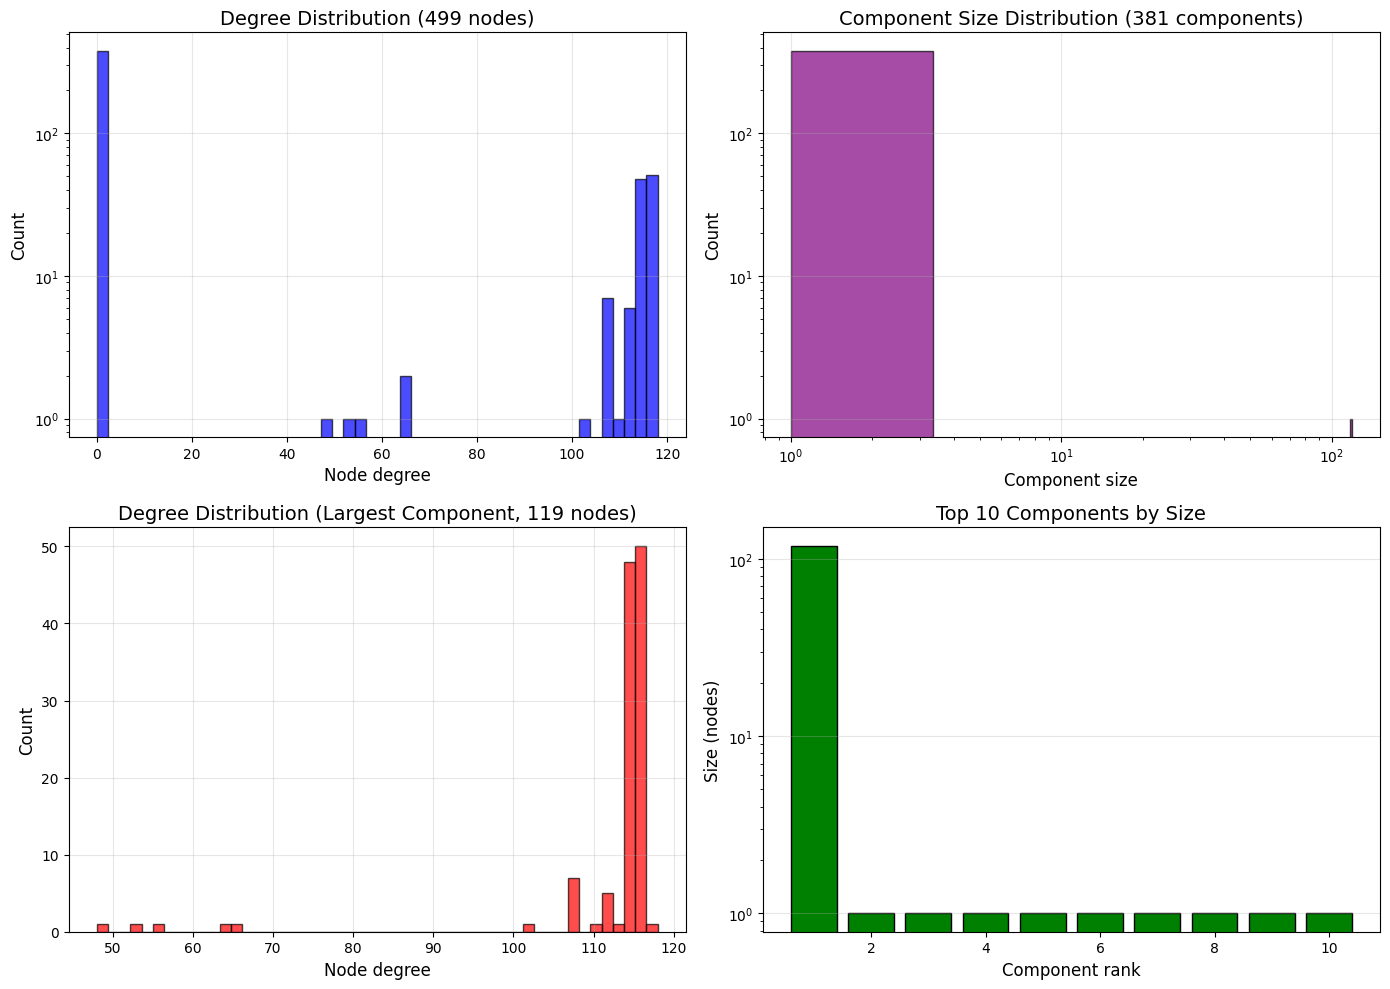

✓ Visualizations complete


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

# Panel 1: Degree distribution
ax = axes[0, 0]
ax.hist(degree.cpu().numpy(), bins=50, alpha=0.7, color='blue', edgecolor='black')
ax.set_xlabel('Node degree', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Degree Distribution ({n_unique:,} nodes)', fontsize=14)
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Panel 2: Component size distribution
ax = axes[0, 1]
if len(sizes) > 1:
    ax.hist(sizes, bins=min(50, len(sizes)), alpha=0.7, color='purple', edgecolor='black')
    ax.set_xlabel('Component size', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Component Size Distribution ({n_components:,} components)', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Only 1 component\n(fully connected)', 
            ha='center', va='center', transform=ax.transAxes, fontsize=14)

# Panel 3: Degree distribution within largest component
ax = axes[1, 0]
ax.hist(largest_degrees.cpu().numpy(), bins=50, alpha=0.7, color='red', edgecolor='black')
ax.set_xlabel('Node degree', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Degree Distribution (Largest Component, {n_largest:,} nodes)', fontsize=14)
ax.grid(True, alpha=0.3)

# Panel 4: Component sizes (bar chart of top 10)
ax = axes[1, 1]
top_n = min(10, len(sizes))
ax.bar(range(1, top_n + 1), sizes[:top_n], color='green', edgecolor='black')
ax.set_xlabel('Component rank', fontsize=12)
ax.set_ylabel('Size (nodes)', fontsize=12)
ax.set_title(f'Top {top_n} Components by Size', fontsize=14)
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

## Summary

In [12]:
print("="*80)
print("ADJACENCY GRAPH ANALYSIS SUMMARY")
print("="*80)
print()
print(f"Threshold:          ε = {epsilon:.6e} (2×ULP)")
print(f"Nodes:              {n_unique:,}")
print(f"Edges:              {n_edges:,}")
print(f"Graph density:      {100*density:.2f}%")
print()
print(f"Connected components: {n_components:,}")
print(f"Largest component:    {sizes[0]:,} nodes ({100 * sizes[0] / n_unique:.1f}%)")
print(f"Largest density:      {100*largest_density:.2f}%")
print()
print(f"Singletons (isolated): {n_singletons:,} ({100 * n_singletons / n_unique:.1f}%)")
print()
print(f"Black holes:           {n_bh_unique} unique vectors")
print(f"BH in largest comp:    {max_bh_count} ({100 * max_bh_count / n_bh_unique:.1f}%)")
print()
print("="*80)

ADJACENCY GRAPH ANALYSIS SUMMARY

Threshold:          ε = 3.051758e-05 (2×ULP)
Nodes:              499
Edges:              6,675
Graph density:      5.37%

Connected components: 381
Largest component:    119 nodes (23.8%)
Largest density:      95.07%

Singletons (isolated): 380 (76.2%)

Black holes:           13 unique vectors
BH in largest comp:    12 (92.3%)



## Conclusion

**Key findings:**
- Number and size of connected components
- Structure of largest component (density, degrees)
- Black hole distribution across components
- Singleton count (isolated vectors)

**Interpretation:**
- If density ≈ 1.0: Complete graph (all nodes mutually connected)
- If most nodes in one large component: Cohesive cluster structure
- If many small components: Fragmented, multiple sub-clusters
- If many singletons: Sharp boundary effect (void around cluster)

**Next steps:**
- 09.2b: Network visualization
- 09.2c: Token decoding and semantic analysis
- 09.2d: Geometric structure (PCA, embedding)